In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [9]:
def CNN_BiLSTM_pred(filename):
    # Check for a GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the dataset
    df = pd.read_csv('data/'+filename+'.csv')

    # Select features to use for prediction
    features = df[['open', 'high', 'low', 'close', 'pct_chg', 'vol', 'amount', 'pre_close']]

    # Normalize the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    # Function to create a dataset with look back
    def create_dataset(data, look_back=10):
        X, Y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:(i + look_back), :])
            Y.append(data[i + look_back, 3])  # index 3 is the 'close' column
        return np.array(X), np.array(Y)

    # Split into train and test sets
    train_size = int(len(scaled_features) * 0.95)
    test_size = len(scaled_features) - train_size
    train, test = scaled_features[0:train_size, :], scaled_features[train_size:len(scaled_features), :]

    # Create the dataset with look back
    look_back = 10
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Convert the datasets to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.astype(np.float32)).to(device)
    Y_train_tensor = torch.tensor(Y_train.astype(np.float32)).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test.astype(np.float32)).to(device)
    Y_test_tensor = torch.tensor(Y_test.astype(np.float32)).view(-1, 1).to(device)

    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Define the CNN-BiLSTM model
    class CNNBiLSTM(nn.Module):
        def __init__(self):
            super(CNNBiLSTM, self).__init__()
            self.conv1d = nn.Conv1d(in_channels=8, out_channels=64, kernel_size=2)
            self.max_pool = nn.MaxPool1d(kernel_size=2)
            self.bilstm = nn.LSTM(input_size=64, hidden_size=50, batch_first=True, bidirectional=True)
            self.fc = nn.Linear(50*2, 1)

        def forward(self, x):
            x = x.transpose(1, 2)  # Conv1D expects (batch_size, channels, seq_len)
            x = torch.relu(self.conv1d(x))
            x = self.max_pool(x)
            x = x.transpose(1, 2)  # LSTM expects (batch_size, seq_len, features)
            x, _ = self.bilstm(x)
            x = self.fc(x[:, -1, :])  # We only care about the last output for the sequence
            return x

    model = CNNBiLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Train the model
    epochs = 10
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_predict = model(X_train_tensor).cpu().numpy()
        test_predict = model(X_test_tensor).cpu().numpy()

    # Invert predictions
    # ... [similar to the Keras example to invert the scaling]

    # Calculate metrics
    test_mae = mean_absolute_error(Y_test, test_predict)
    test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
    test_r2 = r2_score(Y_test, test_predict)

    print(f"Test MAE: {test_mae}")
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R2 Score: {test_r2}")

    # Plot baseline and predictions
    plt.figure(figsize=(12,6))
    plt.plot(Y_test, label='Actual Close Price')
    plt.plot(test_predict, label='Predicted Close Price')
    plt.title('Stock Price Prediction - Actual vs. Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.savefig('CNN_BiLSTM_'+filename+'.png')
    return test_mae, test_rmse, test_r2

Epoch 1/10, Loss: 8.228312253777403e-06
Epoch 2/10, Loss: 8.960818377090618e-05
Epoch 3/10, Loss: 5.780610445071943e-05
Epoch 4/10, Loss: 0.00023021498054731637
Epoch 5/10, Loss: 1.8067228666041046e-05
Epoch 6/10, Loss: 2.1058972379250918e-06
Epoch 7/10, Loss: 7.564646512037143e-05
Epoch 8/10, Loss: 1.561113640491385e-05
Epoch 9/10, Loss: 0.0002593103563413024
Epoch 10/10, Loss: 0.00014681406901217997
Test MAE: 0.02535446732958633
Test RMSE: 0.03158170748671002
Test R2 Score: 0.8582838804320743
Epoch 1/10, Loss: 0.0005918426322750747
Epoch 2/10, Loss: 6.082123582018539e-05
Epoch 3/10, Loss: 4.931383591610938e-05
Epoch 4/10, Loss: 0.0010334642138332129
Epoch 5/10, Loss: 0.0017556315287947655
Epoch 6/10, Loss: 0.0002007728035096079
Epoch 7/10, Loss: 0.000744874298106879
Epoch 8/10, Loss: 0.0003274537739343941
Epoch 9/10, Loss: 8.601113950135186e-05
Epoch 10/10, Loss: 5.238158337306231e-05
Test MAE: 0.00520429205580461
Test RMSE: 0.006279697010215188
Test R2 Score: -5.122020401592684
Epoc

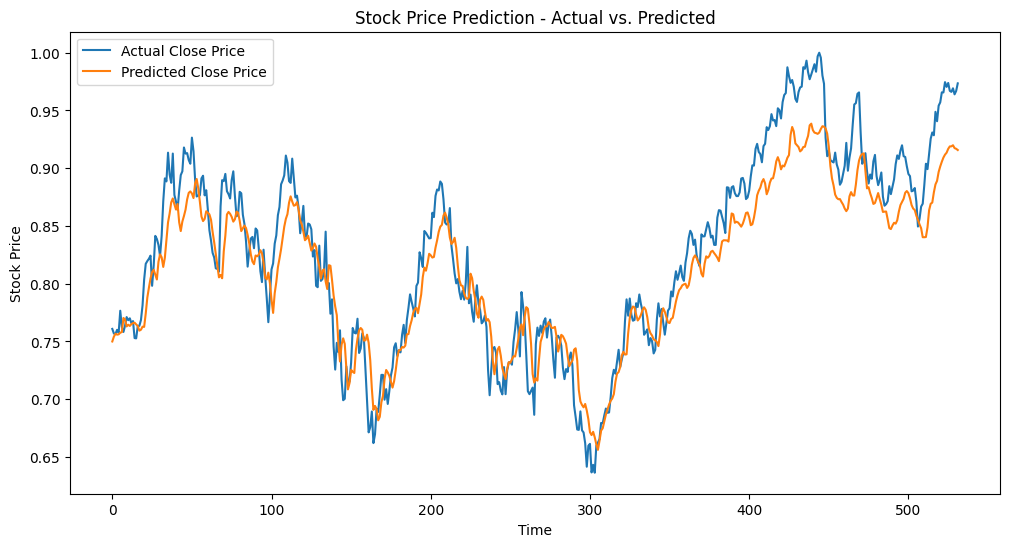

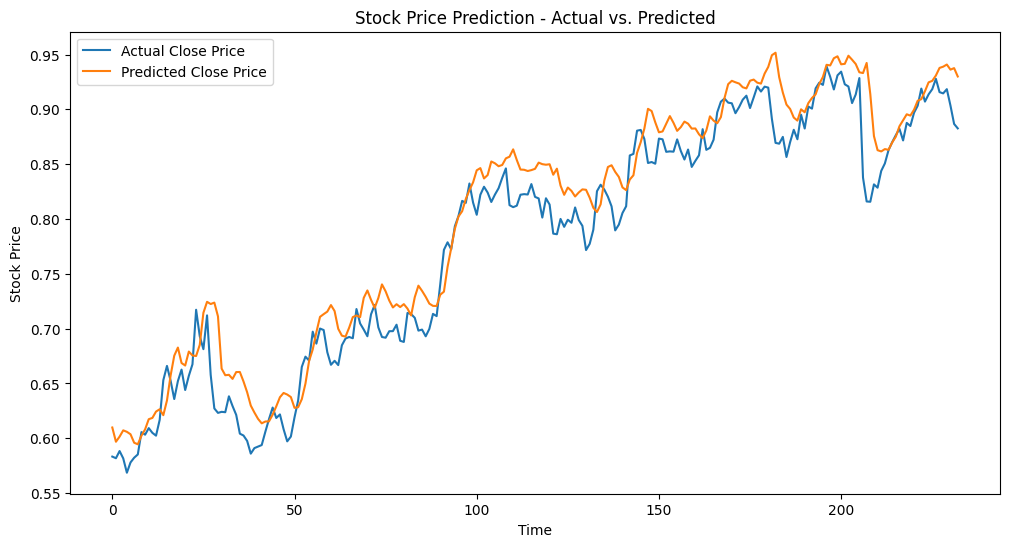

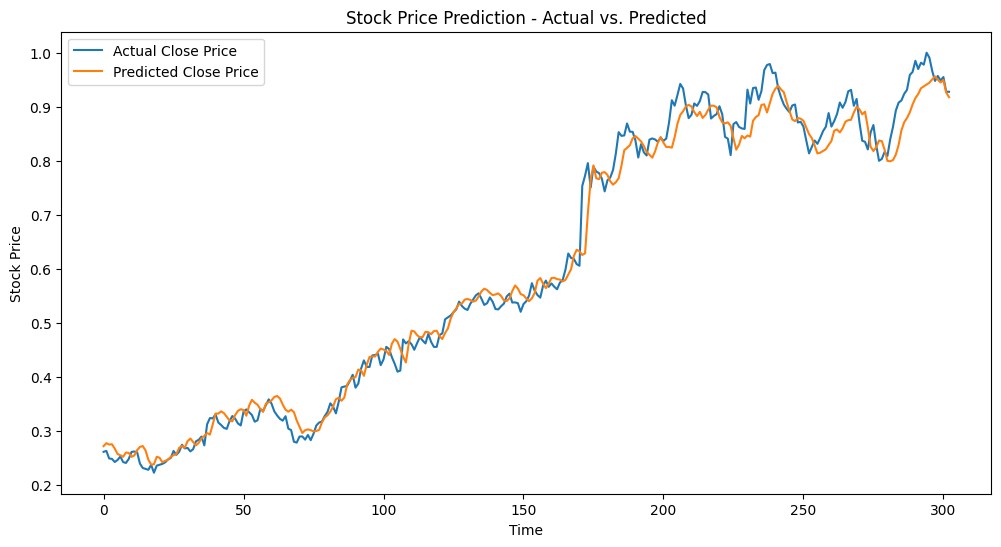

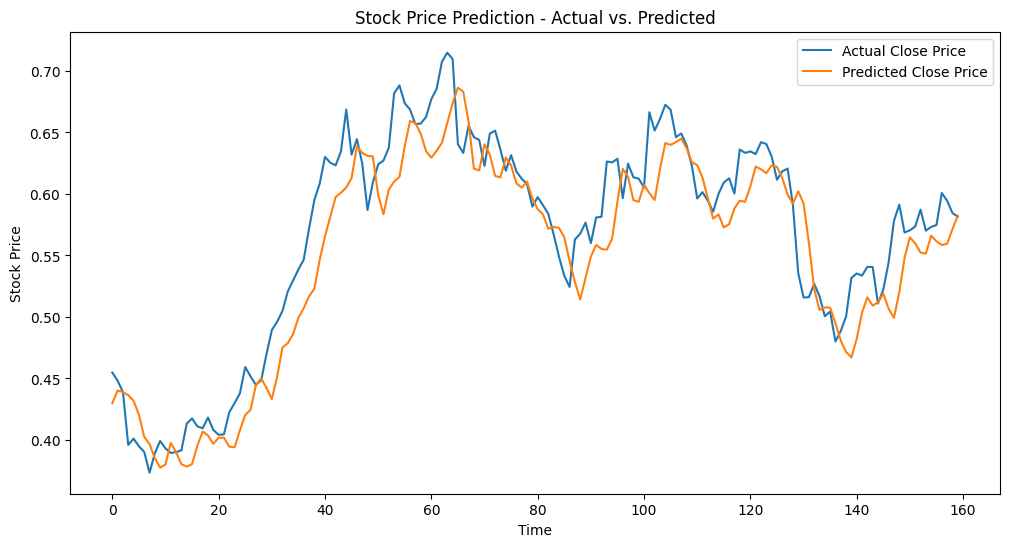

In [11]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames[:]:
    x,y,z = CNN_BiLSTM_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)

In [15]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([max(i,0) for i in r2s if i > 0]).mean())

0.02018103295269024
0.02579604190745851
0.8979809340000754
